Super confused by this.
- Seems like the density is wrong. Based on the stochastic template bank, it should be concentrated at the low-mass corner of the space rather than the high-low corner. I didn't think we had this issue in the past. I need to just find a paper to compare with.
- As a result, the spatial distribution of the templates and effectualnesses is quite different between the banks.

In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from diffbank.metric import get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import (
    gen_bank,
    get_m1_m2_sampler,
    get_match,
    gen_template_rejection,
    get_bank_effectualness,
)
from diffbank.stochastic import gen_bank_stochastic as _gen_bank_stochastic
from diffbank.waveforms.threePN_simple import Psi, amp

In [22]:
key = random.PRNGKey(71)

minimum_match = 0.95
eta = 0.99
fs = jnp.linspace(20.0, 2000.0, 300)
# m_range = (1.0, 3.0)
m_range = (2.5, 3.0)
sampler = get_m1_m2_sampler(m_range, m_range)

density_fun = lambda theta: get_density(theta, amp, Psi, fs, Sn_aLIGO)
density_max = density_fun(jnp.array([m_range[1], m_range[0]]))

## LazyBank

In [23]:
key, key_bank = random.split(key)
templates, eff_pts = gen_bank(
    key_bank,
    density_max,
    sampler,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    eta,
    alpha=0.1,
)

n_eff = 268


  0%|          | 0/268 [00:00<?, ?it/s]

In [37]:
key, key_eff = random.split(key)
effs, eff_pts, eta, eta_err = get_bank_effectualness(
    key_eff,
    templates,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    1000,
    base_dist=sampler,
    density_max=density_max,
    #     eff_pt_sampler=lambda key: sampler(key, 1)[0]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

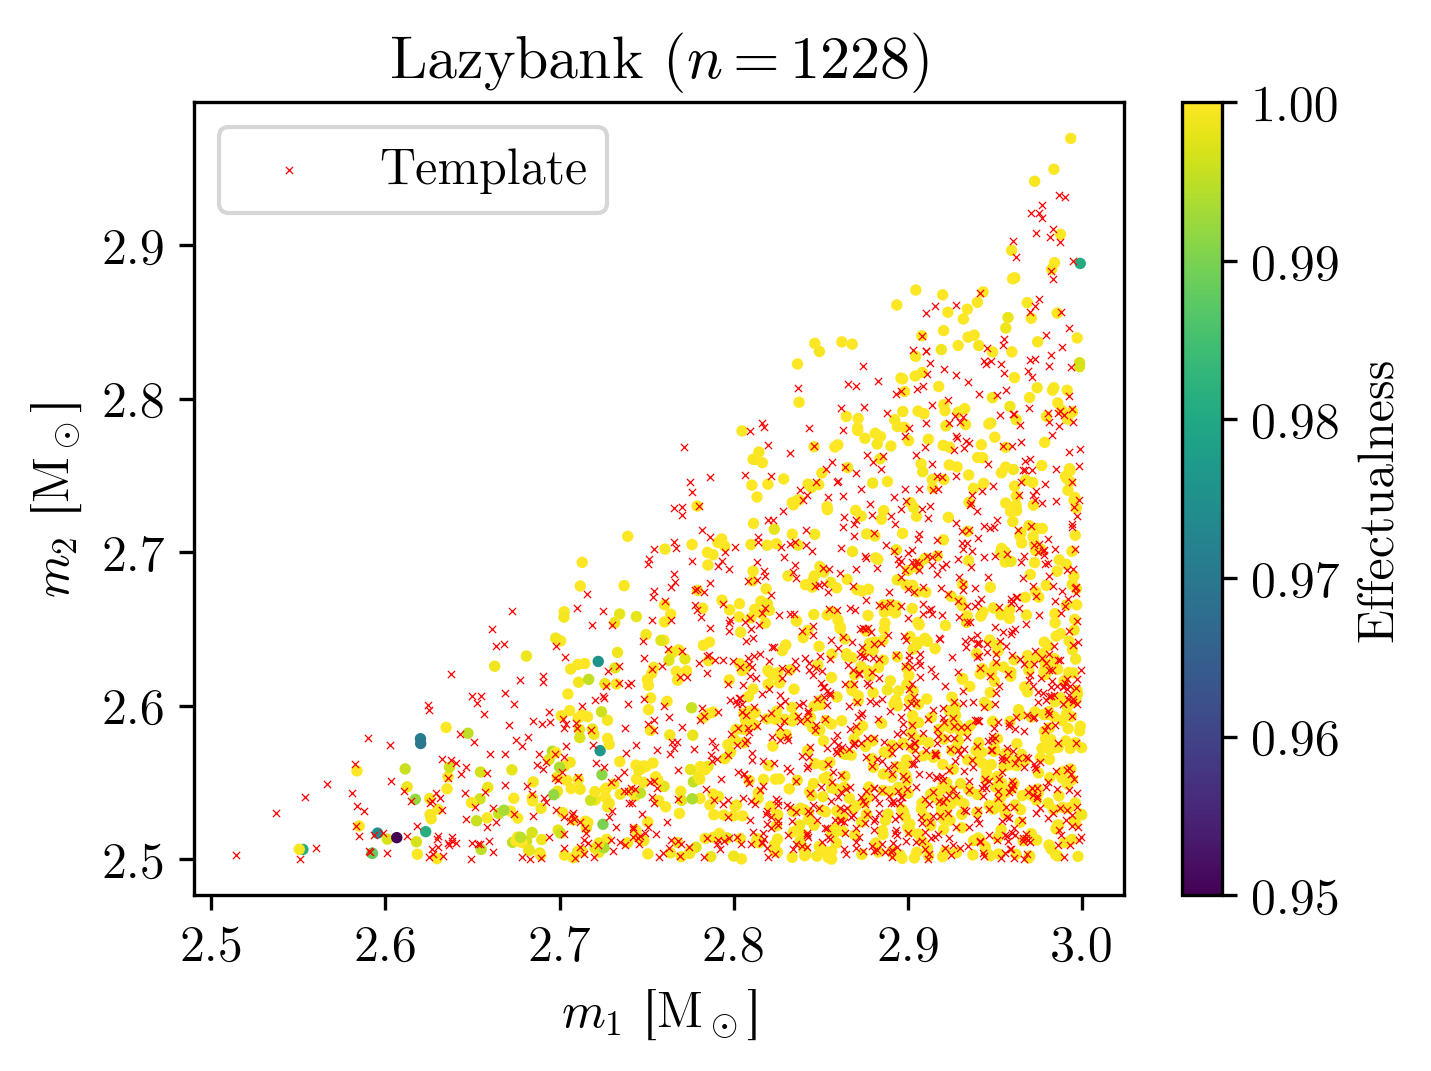

In [38]:
plt.scatter(*eff_pts.T, s=3, c=effs, vmin=minimum_match, vmax=1)
plt.colorbar(label="Effectualness")
plt.scatter(*templates.T, s=3, c="r", linewidth=0.3, marker="x", label="Template")
plt.legend()
plt.title(f"Lazybank ($n = %g$)" % len(templates))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

## Stochastic bank

In [42]:
key = random.PRNGKey(82)
key, key_bank = random.split(key)

gen_template = jax.jit(
    lambda key: gen_template_rejection(key, density_max, density_fun, sampler)
)

gen_bank_stochastic = jax.jit(
    lambda key: _gen_bank_stochastic(
        key, gen_template, amp, Psi, fs, Sn_aLIGO, minimum_match, 90
    )
)

In [43]:
templates_stochastic, n_rejects = gen_bank_stochastic(key_bank)

  1%|1         | 1/90 [00:00<?, ?it/s]

In [44]:
key, key_eff = random.split(key)
(
    effs_stochastic,
    eff_pts_stochastic,
    eta_stochastic,
    eta_err_stochastic,
) = get_bank_effectualness(
    key_eff,
    templates_stochastic,
    amp,
    Psi,
    fs,
    Sn_aLIGO,
    minimum_match,
    1000,
    base_dist=sampler,
    density_max=density_max,
    #     eff_pt_sampler=lambda key: sampler(key, 1)[0]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

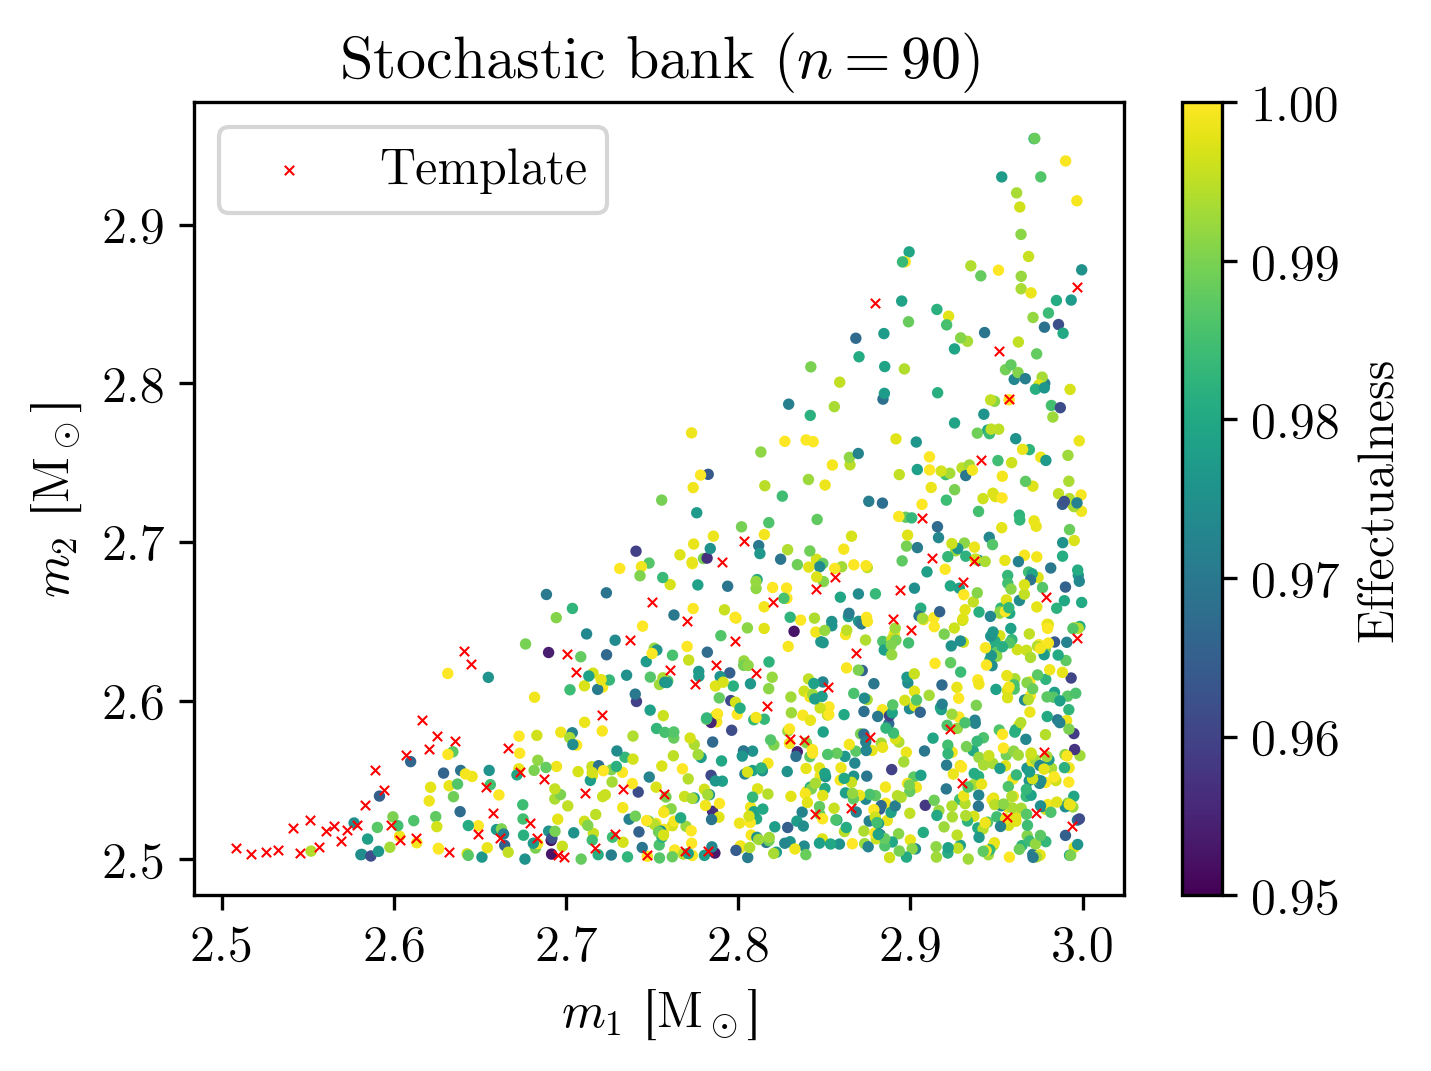

In [48]:
plt.scatter(*eff_pts_stochastic.T, s=3, c=effs_stochastic, vmin=minimum_match, vmax=1)
plt.colorbar(label="Effectualness")
plt.scatter(
    *templates_stochastic.T, s=5, c="r", linewidth=0.5, marker="x", label="Template"
)
plt.legend()
plt.title(f"Stochastic bank ($n = %g$)" % len(templates_stochastic))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

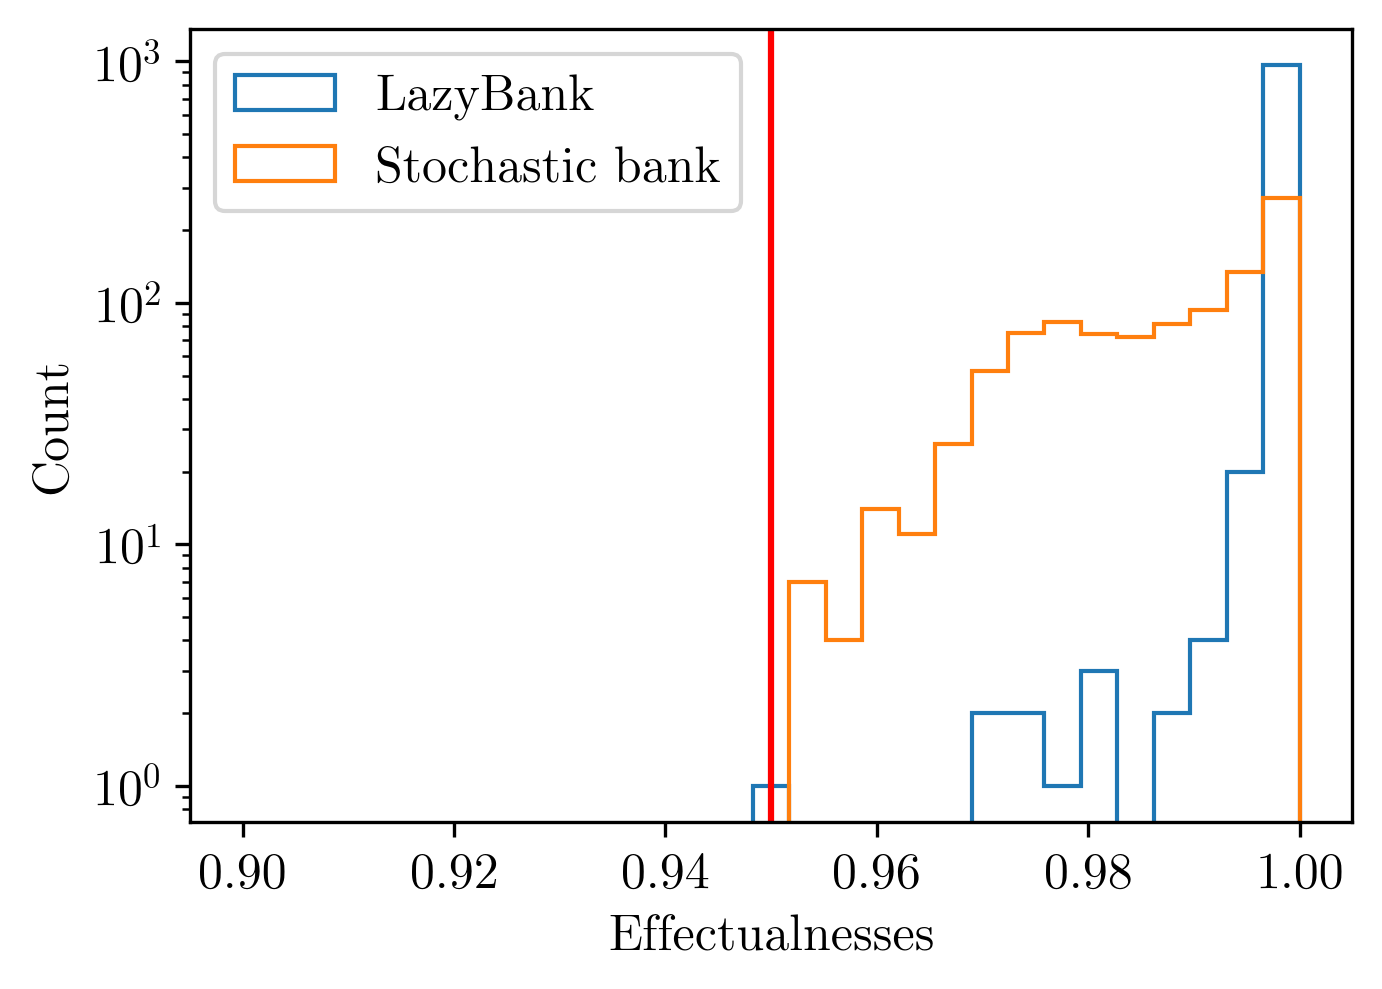

In [46]:
bins = jnp.linspace(0.9, 1.0, 30)
plt.hist(effs, histtype="step", bins=bins, label="LazyBank")
plt.hist(effs_stochastic, histtype="step", bins=bins, label="Stochastic bank")
plt.axvline(minimum_match, color="r")
plt.legend(loc="upper left")
plt.xlabel("Effectualnesses")
plt.ylabel("Count")
plt.yscale("log")